# Promotion Group Identification and Conversion Prediction

## Problem Description
Specifying a group for promotion and predicting the probability of purchase of a user can help devise a scheme to maximize incremental revenue.


## Project Description
In this challenge, historical data `users.csv`, `sessions.csv`, `spendevents.csv`, `iaps.csv`, whoes data frame are renamed `users`, `sessions`, `spendings`, `purcashes`, are analyzed. Based on the analysis, a target group for the promotion is identified with rationales elaborated. Finally, machine learning is employed to predict the probability of conversion based on its paramerters. 

A detailed data description can be accessed from `Homework Instructions.pdf` or the problem instruction.

In overall, the following procedures were done in this project, including: 

1. Preprocess, clean, analyze and visualized the provided data.

2. Feature engineering

3. Model building, performance evaluation and prediction. 

4. Summary and recommendation.

# Table of  Contents

- Part 1 Pre-model Analysis
  - 1.1 Data set overview
  - 1.2 Target feature processing and visualization
  
  
- Part 2 Feature Engineering
  
- Part 3 Machine Learning Model
  - 3.1 Model selection and comparision
  - 3.2 Model hyperparameter tuning


- Part 4 Machine Learning Prediction

- Part 5 Project Summary

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')

from numpy import arange, argmax
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib.gridspec import GridSpec

# Part 1. Pre-model Analysis

## 1.1 Data set overview

In [2]:
# Loding the data
users = pd.read_csv('./Data/users.csv')
sessions = pd.read_csv('./Data/sessions.csv').drop(['last_session_termination_type'], axis=1)
spendings = pd.read_csv('./Data/spendevents.csv')
purchases = pd.read_csv('./Data/iaps.csv')

In [3]:
# Data Information, including shape and type
sessions.info(), spendings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722955 entries, 0 to 722954
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      722955 non-null  int64 
 1   ts           722955 non-null  object
 2   date         722955 non-null  object
 3   session_num  722955 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 22.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107764 entries, 0 to 107763
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    107764 non-null  int64 
 1   ts         107764 non-null  object
 2   date       107764 non-null  object
 3   story      107764 non-null  object
 4   chapter    107764 non-null  int64 
 5   spendtype  106420 non-null  object
 6   currency   107764 non-null  object
 7   amount     107764 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 6.6+ MB


(None, None)

In [4]:
# Check if the dataset contains duplicate observation; 
# if true, consider to remove the duplicates.
print('Any duplicates in Users? ', users.duplicated().any())
print('Any duplicates in Sessions? ', sessions.duplicated().any())
print('Any duplicates in Spendings? ', spendings.duplicated().any())
print('Any duplicates in Purchases? ', purchases.duplicated().any())
# pm_raw = pm_raw.drop_duplicates()

Any duplicates in Users?  False
Any duplicates in Sessions?  True
Any duplicates in Spendings?  True
Any duplicates in Purchases?  True


- There are some duplicate record in `sessions`, `spendings`, and `purchases`. Since these duplicates have different index, considering the model is to give an probaility in overall based on all players and all sessions, it is decided keep those duplicate records.

In [5]:
# define a function for checking the missing percentage of each column
def calculate_missing_perc(x):
    '''
    function: check the percentage of missing value of each column in a dataframe
    input: dataframe
    output: dictionary
    '''
    dic = {}
    for feature in x.columns:
        perc = round(x[feature].isnull().sum()/len(x)*100, 2)
        dic[feature] = str(perc) + '%'
    
    return dic

In [6]:
calculate_missing_perc(users), calculate_missing_perc(spendings)

({'user_id': '0.0%',
  'install_date': '0.0%',
  'lang': '0.0%',
  'country': '0.05%',
  'hw_ver': '0.0%',
  'os_ver': '0.0%'},
 {'user_id': '0.0%',
  'ts': '0.0%',
  'date': '0.0%',
  'story': '0.0%',
  'chapter': '0.0%',
  'spendtype': '1.25%',
  'currency': '0.0%',
  'amount': '0.0%'})

In [7]:
# drop all records with missing price value
spendings.dropna(subset=['spendtype'], inplace = True)

**Part Summary**
- A minimal fraction of missing values (0.05% and 1.25%) were observed for `country` in `users` and `spendtype` in `spendings`. 

- Though the missing data of `country` in `users` is minmal which can be dropped usually, it is kept in this case since the information of users are important for matching the records in other datasets. 

- As for `spendtype` in `spendings`, it is decided to be removed from the whole data set rather do imputation which may bring bias to the model. 

## 1.2 Feature processing and visualization

Ahead of processing the target feature (to be identified), the data set is visualized and analyzed first. It is should be noted that `sessions`, `spendings`, `purcashes` only contains `user_id`. Therefore, data set merging may be needed to retrieve the detailed information of thoses users apprearing.  

### **(1) Users Analysis**

In [8]:
#Convert install_date from str to datetime format
users['install_date'] = pd.to_datetime(users['install_date'])

In [9]:
users.head()

,user_id,install_date,lang,country,hw_ver,os_ver
0,0,2019-03-01,en,US,"iPhone4,1",9.1
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2
2,2,2019-03-06,en,US,"iPod7,1",8.4.1
3,3,2019-03-03,nb,NO,"iPhone8,1",9.2.1
4,4,2019-03-03,en,GB,"iPhone5,4",9.2.1


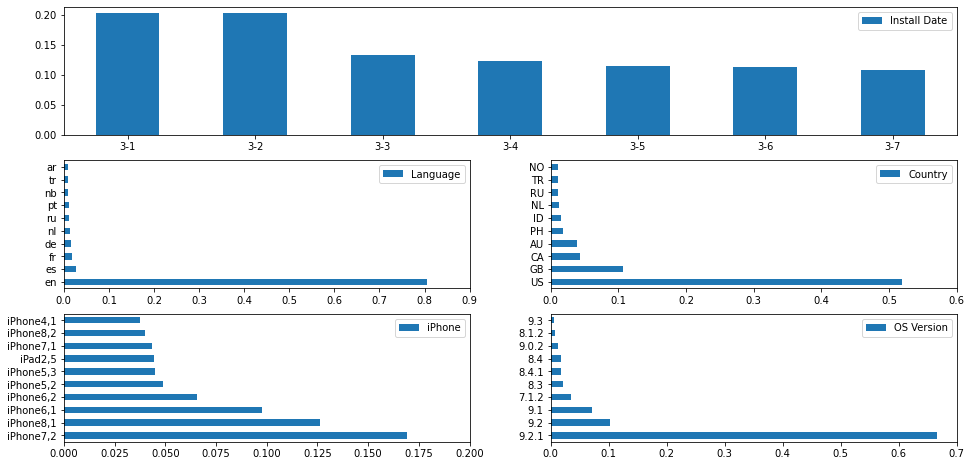

In [10]:
# # Plot the top 10 in each feature
fig = plt.figure(figsize=(16,8))

gs = GridSpec(3,2)

ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,0])
ax3=fig.add_subplot(gs[1,1])
ax4=fig.add_subplot(gs[2,0])
ax5=fig.add_subplot(gs[2,1])

users.install_date.value_counts(normalize=True, ascending=False)[0:10].plot(kind='bar', ax=ax1)
users.lang.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=ax2)
users.country.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=ax3)
users.hw_ver.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=ax4)
users.os_ver.value_counts(normalize=True,ascending=False)[0:10].plot(kind='barh', ax=ax5)

xlabels = ['3-1', '3-2', '3-3', '3-4', '3-5', '3-6', '3-7']
ax1.set_xticklabels(xlabels, rotation=0)

ax2.set_xlim(0, 0.9)
ax3.set_xlim(0, 0.6)
ax4.set_xlim(0, 0.2)
ax5.set_xlim(0, 0.7)

ax1.legend(['Install Date'], loc="best")
ax2.legend(['Language'], loc="best")
ax3.legend(['Country'], loc="best")
ax4.legend(['iPhone'], loc="best")
ax5.legend(['OS Version'], loc="best")

plt.show()

**Part Summary**
- 50% users install in the first three days (3-1 to 3-3), and the install graduately declines.

- Most of the users (~80%) are speaking English, from countries, U.S, Great Britain, Canada and Austrilia. 

- These users use diffrent devices, including the older iPhone 4 and the newer iPhone 8, and even iPad. But most of the devices are upgraded to the lasted os version (9.2.1, ~65%)

- If we need to target a specific group, the english speaking countries may be a good choice as they contirbute most of the users. This can be later decided according to the revenue contribution of them.

### **(2) Sessions Analysis**

In [11]:
#Left merger with users
sessions_users = pd.merge(sessions, users, how="left", on=["user_id"])

# create a new dataframe with time as the index
to_be_dropped = ['ts','date']
sessions_users.index = pd.to_datetime(sessions_users.ts)
sessions_users = sessions_users.drop(to_be_dropped,axis=1)

In [12]:
# Add `actual_duration` 
sessions_users['session_month'] =  sessions_users.index.month
sessions_users['session_day'] =  sessions_users.index.day
sessions_users['session_hour'] =  sessions_users.index.hour
sessions_users['session_weekday'] =  sessions_users.index.weekday
sessions_users['session_loyalty'] =  (sessions_users.index -  sessions_users.install_date).dt.days
# cat_train = cat_train.reset_index(drop=True)

In [13]:
sessions_users.head()

,user_id,session_num,install_date,lang,country,hw_ver,os_ver,session_month,session_day,session_hour,session_weekday,session_loyalty
ts,,,,,,,,,,,,
2019-03-01 00:06:50,14067,1,2019-03-01,en,GB,"iPad2,6",9.2.1,3,1,0,4,0
2019-03-01 00:22:27,14067,2,2019-03-01,en,GB,"iPad2,6",9.2.1,3,1,0,4,0
2019-03-01 01:23:03,16275,1,2019-03-01,ru,RU,"iPhone7,2",9.2.1,3,1,1,4,0
2019-03-01 01:31:16,16275,2,2019-03-01,ru,RU,"iPhone7,2",9.2.1,3,1,1,4,0
2019-03-01 01:47:22,16275,3,2019-03-01,ru,RU,"iPhone7,2",9.2.1,3,1,1,4,0


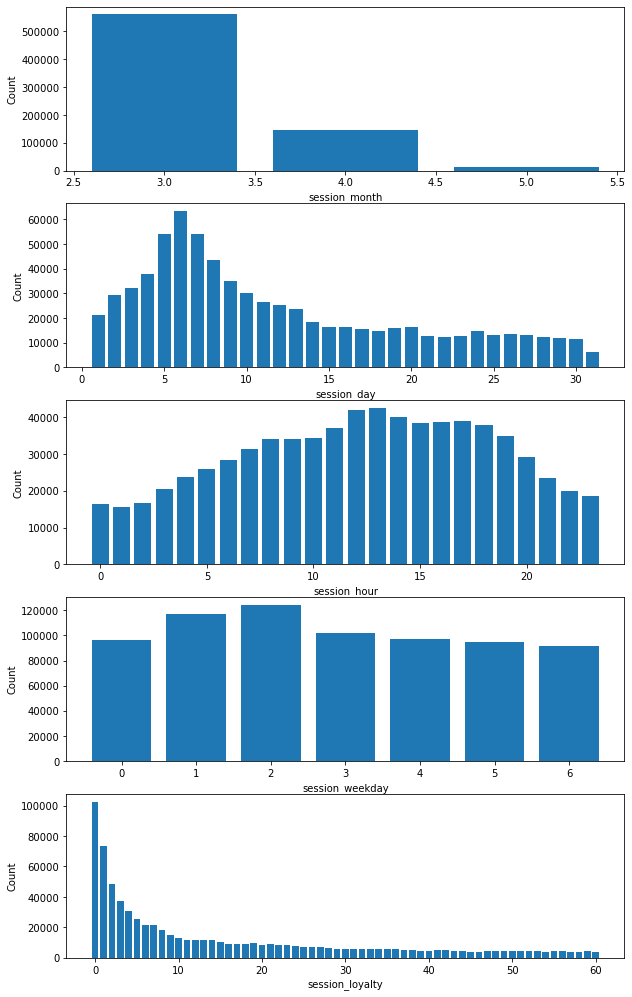

In [14]:
# Plot average actual_duration vs data features 

time_features = ['session_month', 'session_day', 'session_hour', 'session_weekday', 'session_loyalty']
def plot_time_feature(df, features):
    row = len(features)
    col = 1
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(10,3.5*row))
    
    for i, f in enumerate(features):
        ax[i].bar(df.groupby(f)['user_id'].groups.keys(),
            df.groupby(f)['user_id'].count(), width=0.8, align='center')
        
        ax[i].set_xlabel(f)
        ax[i].set_ylabel('Count')

plot_time_feature(sessions_users, time_features)
plt.show()

**Part Summary**
- The session data only covered Year 2019; thereafter, such time feature is not included.

- There is a trend that less and less sessions are made along with months. This might be due to the loss of interests of users in this game or either due to the finishing of the game. 

- The monthly trend is same to the trend in days which has a peak at Days 5-6. This should be due to the facts that most of the users installed at these days. 

- More games session are conducted at noon (12:00 and 14:00). This makes sense as during these hours, people would like to play some games to take a rest. And at midnight, there still users playing the games but are very much less than thoese in noon.

- The number of game sessions is higher on Tuesday and Wednesday, but not Saturday and Sunday, which is reasonable, as at the time, users may have less outdoor time but stay in office where playing some games is a good way for entertaiment. 

- The most active day is the first time after installation and the activity sharply decreases in the first week and then keeps steady after 10 days with a slow decline trend. In overall, the first week after installation is the most active period of time. 

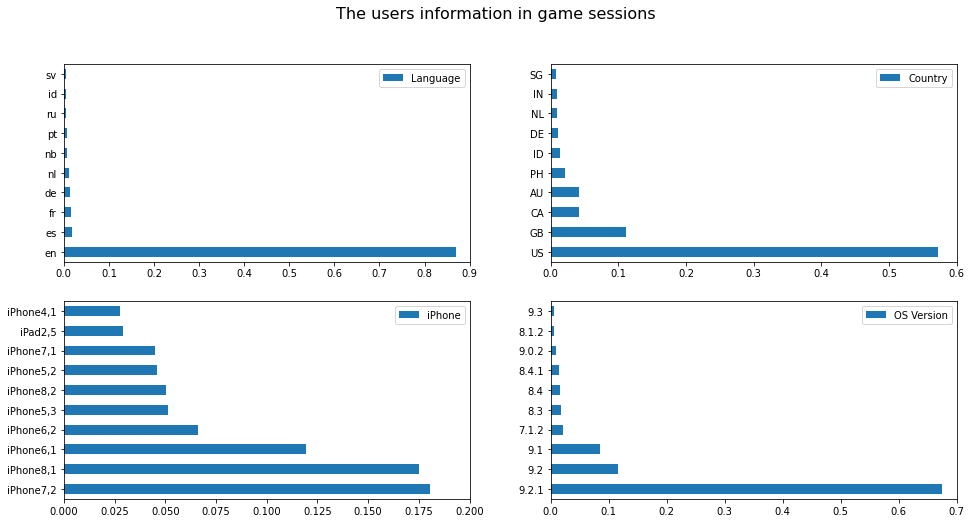

In [15]:
# Plot the top 10 in each feature
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16,8))
fig.suptitle("The users information in game sessions", fontsize=16)

sessions_users.lang.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[0][0])
sessions_users.country.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[0][1])
sessions_users.hw_ver.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[1][0])
sessions_users.os_ver.value_counts(normalize=True,ascending=False)[0:10].plot(kind='barh', ax=axes[1][1])

axes[0][0].set_xlim(0, 0.9)
axes[0][1].set_xlim(0, 0.6)
axes[1][0].set_xlim(0, 0.2)
axes[1][1].set_xlim(0, 0.7)

# axes[0][0].set_ylabel('Language')
# axes[0][1].set_ylabel('Country')
# axes[1][0].set_ylabel('iPhone')
# axes[1][1].set_ylabel('OS Version')

axes[0][0].legend(['Language'], loc="best")
axes[0][1].legend(['Country'], loc="best")
axes[1][0].legend(['iPhone'], loc="best")
axes[1][1].legend(['OS Version'], loc="best")
plt.show()

**Part Summary**
- There observes no significant difference between the users playing games or the users installing the game. 

- In another word, the English speaking countries, inclduing, U.S, Great Britain, Canada and Austrilia, contribute most of the game sessions. It is likely that giving more promotions for these countires may help attract more users and more game sessions, thereby more likely spending or purchases.

### **(3) Spendings Analysis**

In [16]:
#Left merger with users
spendings_users = pd.merge(spendings, users, how="left", on=["user_id"])

# create a new dataframe with time as the index
to_be_dropped = ['ts','date']
spendings_users.index = pd.to_datetime(spendings_users.ts)
spendings_users = spendings_users.drop(to_be_dropped,axis=1)

In [17]:
# Add `actual_duration` 
spendings_users['spending_month'] =  spendings_users.index.month
spendings_users['spending_day'] =  spendings_users.index.day
spendings_users['spending_hour'] =  spendings_users.index.hour
spendings_users['spending_weekday'] =  spendings_users.index.weekday
spendings_users['spending_loyalty'] =  (spendings_users.index -  spendings_users.install_date).dt.days

# cat_train = cat_train.reset_index(drop=True)

In [18]:
spendings_users.head()

,user_id,story,chapter,spendtype,currency,amount,install_date,lang,country,hw_ver,os_ver,spending_month,spending_day,spending_hour,spending_weekday,spending_loyalty
ts,,,,,,,,,,,,,,,,
2019-03-01 03:03:04,9829,story_1,0,earnGemsCounter,gems,-22,2019-03-01,en,US,"iPhone8,1",9.2,3,1,3,4,0
2019-03-01 03:35:53,13757,story_1,0,earnGemsCounter,gems,-22,2019-03-01,en,US,"iPhone6,1",9.2.1,3,1,3,4,0
2019-03-01 03:52:10,13757,story_2,0,earnGemsCounter,gems,-22,2019-03-01,en,US,"iPhone6,1",9.2.1,3,1,3,4,0
2019-03-01 04:10:00,10009,story_1,0,earnGemsCounter,gems,-22,2019-03-01,en,IN,"iPad2,5",8.3,3,1,4,4,0
2019-03-01 04:26:46,10009,story_2,0,earnGemsCounter,gems,-22,2019-03-01,en,IN,"iPad2,5",8.3,3,1,4,4,0


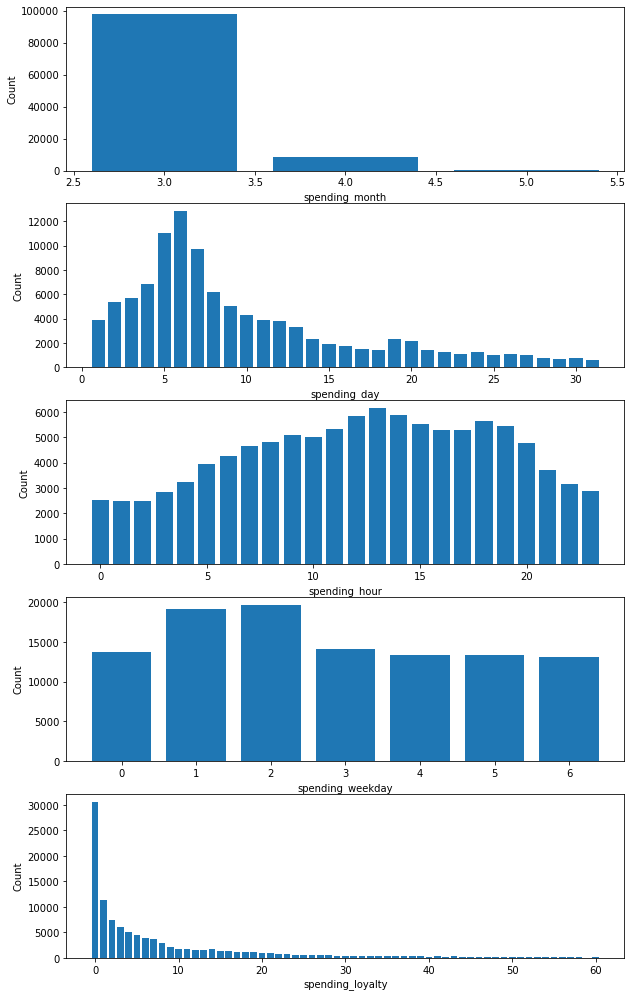

In [19]:
# Plot average actual_duration vs data features 
time_features = ['spending_month', 'spending_day', 'spending_hour', 'spending_weekday', 'spending_loyalty']
plot_time_feature(spendings_users, time_features)
plt.show()

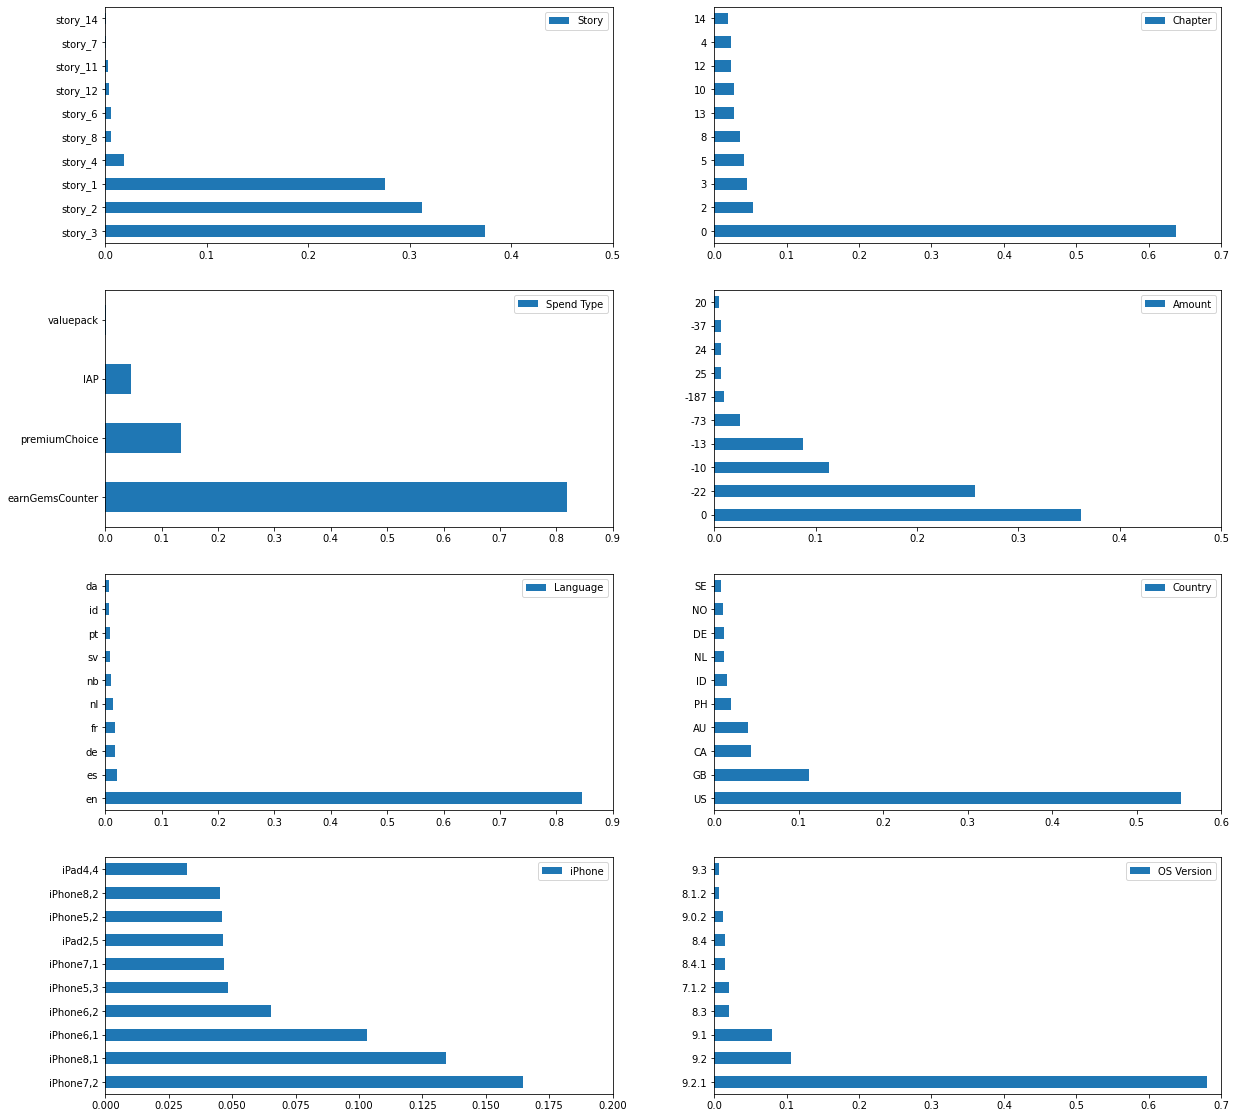

In [20]:
# Plot the top 10 in each feature
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(20,20))
# fig.suptitle("The spending information in game spendings", fontsize=16)

spendings_users.story.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[0][0])
spendings_users.chapter.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[0][1])
spendings_users.spendtype.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[1][0])
spendings_users.amount.value_counts(normalize=True,ascending=False)[0:10].plot(kind='barh', ax=axes[1][1])

axes[0][0].set_xlim(0, 0.5)
axes[0][1].set_xlim(0, 0.7)
axes[1][0].set_xlim(0, 0.9)
axes[1][1].set_xlim(0, 0.5)

spendings_users.lang.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[2][0])
spendings_users.country.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[2][1])
spendings_users.hw_ver.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[3][0])
spendings_users.os_ver.value_counts(normalize=True,ascending=False)[0:10].plot(kind='barh', ax=axes[3][1])

axes[2][0].set_xlim(0, 0.9)
axes[2][1].set_xlim(0, 0.6)
axes[3][0].set_xlim(0, 0.2)
axes[3][1].set_xlim(0, 0.7)

# axes[0][0].set_ylabel('Language')
# axes[0][1].set_ylabel('Country')
# axes[1][0].set_ylabel('iPhone')
# axes[1][1].set_ylabel('OS Version')

axes[0][0].legend(['Story'], loc="best")
axes[0][1].legend(['Chapter'], loc="best")
axes[1][0].legend(['Spend Type'], loc="best")
axes[1][1].legend(['Amount'], loc="best")

axes[2][0].legend(['Language'], loc="best")
axes[2][1].legend(['Country'], loc="best")
axes[3][0].legend(['iPhone'], loc="best")
axes[3][1].legend(['OS Version'], loc="best")
plt.show()

**Part Summary**
- The time aggregation in spending shows similar trend to that of the game sessions, which is reasonable as the more sessions the more spendings. 

- Similarly, the most active day in spending is the first day after installation and the total spendings sharply decrease in the first week and then keeps steady after 10 days with a slow decline trend. In overall, the first week after installation is the most active period of time in spending. 

- As for the spendings, most of them are on the intial stages, from story_1 to story_3 majorly through `earnGemsCounter` and minimal portions are via purchasing. 

- All spendings are made using gems as the currency.

- There observes no significant difference between the users spending in games and thoes playing or  installing the game. 

- The English speaking countries, inclduing, U.S, Great Britain, Canada and Austrilia, are still the most contributive powers in spendings.  

### **(4) Purchase Analysis**

In [21]:
#Left merger with users
purchases_users = pd.merge(purchases, users, how="left", on=["user_id"])

# create a new dataframe with time as the index
to_be_dropped = ['ts','date']
purchases_users.index = pd.to_datetime(purchases_users.ts)
purchases_users = purchases_users.drop(to_be_dropped,axis=1)

In [22]:
# Add `actual_duration` 
purchases_users['purchase_month'] =  purchases_users.index.month
purchases_users['purchase_day'] =  purchases_users.index.day
purchases_users['purchase_hour'] =  purchases_users.index.hour
purchases_users['purchase_weekday'] =  purchases_users.index.weekday  
purchases_users['purchase_loyalty'] =  (purchases_users.index -  purchases_users.install_date).dt.days

# cat_train = cat_train.reset_index(drop=True)

In [23]:
purchases_users.head()

,user_id,prod_name,prod_type,rev,install_date,lang,country,hw_ver,os_ver,purchase_month,purchase_day,purchase_hour,purchase_weekday,purchase_loyalty
ts,,,,,,,,,,,,,,
2019-03-04 08:15:49,7480,iap_1_gems_2,gems,760,2019-03-03,en,US,"iPhone7,1",9.2.1,3,4,8,0,1
2019-03-04 08:24:15,7480,iap_1_passes_2,chapterPasses,760,2019-03-03,en,US,"iPhone7,1",9.2.1,3,4,8,0,1
2019-03-04 22:49:08,7480,iap_1_gems_1,gems,410,2019-03-03,en,US,"iPhone7,1",9.2.1,3,4,22,0,1
2019-03-06 00:16:48,2466,iap_1_gems_2,gems,760,2019-03-05,en,CA,"iPhone6,1",9.2.1,3,6,0,2,1
2019-03-06 09:13:45,22001,iap_1_gems_2,gems,760,2019-03-05,en,US,"iPhone8,2",9.2.1,3,6,9,2,1


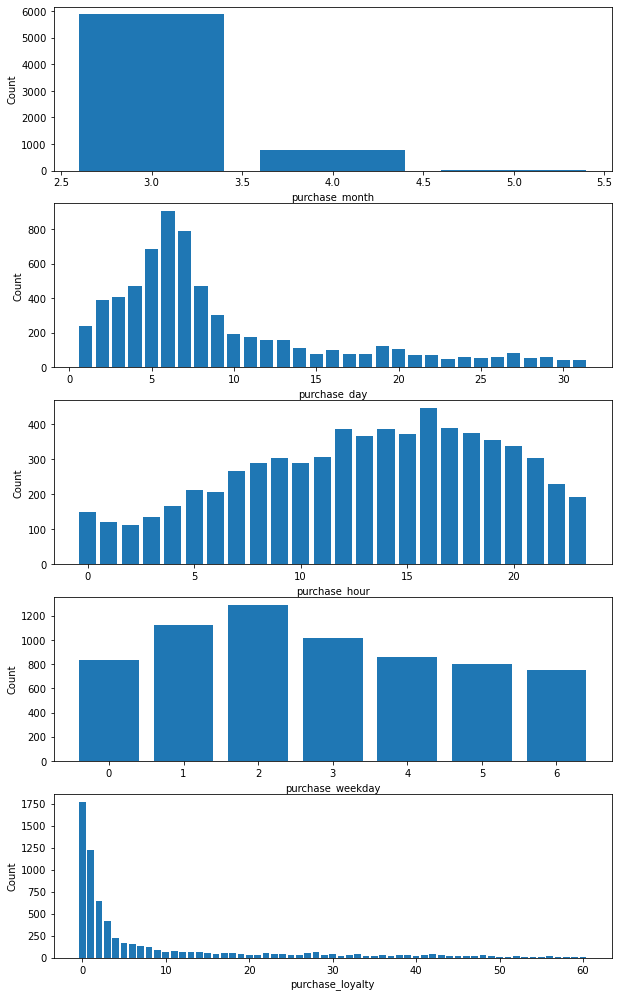

In [24]:
# Plot average actual_duration vs data features 
time_features = ['purchase_month', 'purchase_day', 'purchase_hour', 'purchase_weekday', 'purchase_loyalty']
plot_time_feature(purchases_users, time_features)
plt.show()

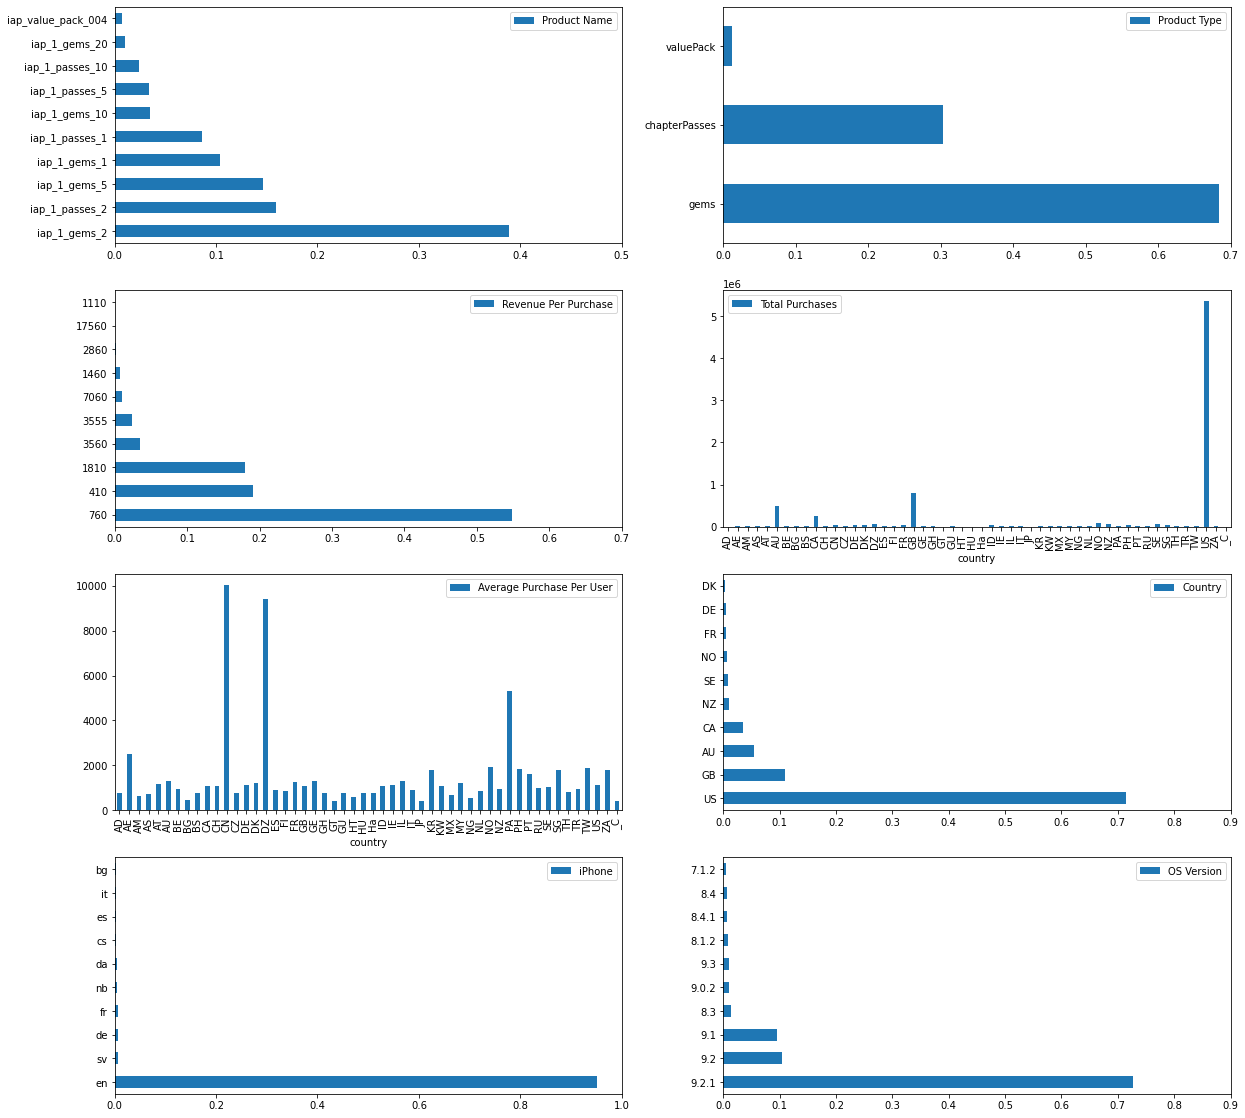

In [25]:
# Plot the top 10 in each feature
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(20,20))
# fig.suptitle("The purchase information", fontsize=16)

purchases_users.prod_name.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[0][0])
purchases_users.prod_type.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[0][1])
purchases_users.rev.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[1][0])
purchases_users.groupby(['country'])['rev'].sum().plot(kind='bar',ax=axes[1][1])
purchases_users.groupby(['country'])['rev'].mean().plot(kind='bar',ax=axes[2][0])

# purchases_users.lang.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[2][0])
purchases_users.country.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[2][1])
purchases_users.lang.value_counts(normalize=True, ascending=False)[0:10].plot(kind='barh', ax=axes[3][0])
purchases_users.os_ver.value_counts(normalize=True,ascending=False)[0:10].plot(kind='barh', ax=axes[3][1])

axes[0][0].set_xlim(0, 0.5)
axes[0][1].set_xlim(0, 0.7)
axes[1][0].set_xlim(0, 0.7)
# axes[1][1].set_xlim(0, 0.5)
# axes[2][0].set_xlim(0, 1)
axes[2][1].set_xlim(0, 0.9)
axes[3][0].set_xlim(0, 1)
axes[3][1].set_xlim(0, 0.9)


# axes[0][0].set_ylabel('Language')
# axes[0][1].set_ylabel('Country')
# axes[1][0].set_ylabel('iPhone')
# axes[1][1].set_ylabel('OS Version')

axes[0][0].legend(['Product Name'], loc="best")
axes[0][1].legend(['Product Type'], loc="best")
axes[1][0].legend(['Revenue Per Purchase'], loc="best")
axes[1][1].legend(['Total Purchases'], loc="best")

axes[2][0].legend(['Average Purchase Per User'], loc="best")
axes[2][1].legend(['Country'], loc="best")
axes[3][0].legend(['iPhone'], loc="best")
axes[3][1].legend(['OS Version'], loc="best")
plt.show()

**Part Summary**
- The time aggregation in purchase shows similar trend to that of the game sessions or spendings, which is reasonable as the more sessions the more purchases. 

- Similarly, the most active day in purchasing is the first day after installation and the total purchases sharply decrease in the first week and then keeps steady after 10 days with a slow decline trend. In overall, the first week after installation is the most active period of time in purchases. 

- As for the purchases, most of them are in the form of gems or chapterPasses, with values mostly in range of 760-1810, and minimal portions are for valuePack or high prices items (>2000). 

- Still the four english speaking, including countries, U.S, Great Britain, Canada and Austrilia, contribute >90% revenues though China, Algeria, and Panama are the countries with highst average purchases.

# Part 2 Data and Feature Engineering

## 2.1 Target group identification

The above part analyzes the information of all the four data sets, including `users`, `sessions`, `spendings` and `purcashes`. It is found that more than 80% users are using English. And this group of people contribute to the most games sessions, spendings and purchases (~85%). 

**As most of contributive users are using English, it is decided to select the English users for this promotion, as a small ratio of users acquisition in purchase due to promotion can contribute large revenue. Since the goal of this assignment is to devise a scheme to maximize incremental revenue, the following model is to predict whether the English users will make purchases. If the probaility is low then promotions may be applied to them to boost purchase and revenue**

As discussed above, the goal is to predict whether a user purchases or generate revenue. There are a lot of features which may be used to do purchase prediction. 

- The information of the users themselves, such as the location, the language, the install date the phones they use.

- The information of how active the users are, such as how many game session they play or how much spending they make and in what chapter or games. 

Applying all these information may be applicable and may give a more accurate purchase prediction. However, the built model can be complicated, which requires to track all the activities, such as the the gaming and spending activities during a period of time, in order to make dynamic prediction and promotion recommendation to a specific user. This requires more dynamic powers and is not easily employed for promotion though it is achievable. It should be noted that the purchase decision may have been highly 'intertwined' with the session or the spending. As it is hardly differentiate whether it is more spending or sessions lead to more purchases, or purchasing results in more games sessions or spendings. **Considering the sessions or spendings may leads to data leakage**. 


Therefore, the following model is to only employ the users' information plus the time features, wuch as `install_date`, `session_date`, as well as `loyalty`, (how long since first install) for purchase prediction. The model may also be employed for purchase prediction for other games in the initial stage to get advancing results without considering which chapter or story the users play or some other game specific features.

## 2.2 Data set prepration

Ahead of processing the target feature, the data sets, including `sessions`, `spendings` and `purchases` are group by `user_id` and `date`. Then these data sets, based on sessions, are merged together into a total new one, via retrieving `date` or `user_id` or both.

Note: this data set as said above only consider the english speaking users.

- The `new_sessions`, `new_spendings` and `new_purchases` datasets are transformed from the original `sessions`, `spendings` and `purchases` datasets  via grouping `user_id` and `date`. 

- Since grouping can ignore some information, aggregation, such as the total number of sessions, or spendigs or purchases made in one day is aggregated, as `session_trials`, `spending_amount` and `rev`, respectively.

In [26]:
# Aggregate the users who play games (session)
session_groups = ['user_id','date']
new_sessions = sessions.groupby(session_groups, as_index=False)['session_num'].agg({'session_trials': 'count'})

# Aggregate the users who make spendings
spending_groups = ['user_id','date']
new_spendings = spendings.groupby(spending_groups, as_index=False)['amount'].agg({'spending_amount': 'sum', 'spending_count': 'count'})

# Aggregate the users who make purchases
purchase_groups = ['user_id', 'date']
new_purchases = purchases.groupby(purchase_groups, as_index=False)['rev'].agg({'rev': 'sum', })

In [27]:
#Merge all the tables together
session_to_purchase = pd.merge(new_sessions, new_spendings, how="left", on=["user_id", 'date'])
session_to_purchase = pd.merge(session_to_purchase, new_purchases, how="left", on=["user_id", 'date'])
session_to_purchase = pd.merge(session_to_purchase, users, how="left", on=["user_id"])

#fill non-spending as 0
session_to_purchase[['spending_amount', 'spending_count']] = session_to_purchase[['spending_amount', 'spending_count']].fillna(value=0)

#convert rev activity as 1 and the other as 0
session_to_purchase['purchase'] = session_to_purchase['rev'].map(lambda x: 1 if not pd.isnull(x) else 0)        
session_to_purchase['loyalty'] = (pd.to_datetime(session_to_purchase['date']) - session_to_purchase['install_date']).dt.days

#only select the English users
session_to_purchase = session_to_purchase[session_to_purchase['lang'].isin(['en'])]

In [28]:
#drop some non-useful columns
to_be_dropped = ['user_id', 'rev', 'lang']
session_to_purchase = session_to_purchase.drop(to_be_dropped,axis=1)
session_to_purchase = session_to_purchase.reset_index(drop=True)

**After the merged dataset is prepared, the data needed for modeling is then prepared**
- The modeling dataset `new_purchases_users` keeps the time features, especially days and weekdays, shows decent variance in affecting the final purchases. 

- `session_trials`, `spending_amount` and `spending_count` are removed to prevent data leakage.

In [29]:
#Create a new dataframe with features in a specific order for clarity
new_purchases_users = pd.DataFrame()
features = ['install_date', 'country', 'hw_ver', 
            'os_ver', 'date', 'purchase']

for x in features:
    new_purchases_users[x] = session_to_purchase[x]

In [30]:
new_purchases_users.head()

,install_date,country,hw_ver,os_ver,date,purchase
0,2019-03-01,US,"iPhone4,1",9.1,2019-03-01,0
1,2019-03-01,US,"iPhone4,1",9.1,2019-03-03,0
2,2019-03-01,US,"iPhone4,1",9.1,2019-03-05,0
3,2019-03-01,IN,"iPod5,1",8.1.2,2019-03-01,0
4,2019-03-01,IN,"iPod5,1",8.1.2,2019-03-02,0


**Part Summary**
- `new_purchases_users`, is the fabricated data set for modeling. 

- It has features, including the users information, such as `country`,  `hw_ver`, `os_ver`.

- Since the activities are affected by the time, all the time features, including `install_date` and the session `date`, are also included.

- The `purchase` is the target feature.

## 2.2 Target feature visualization

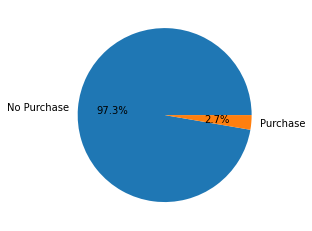

In [31]:
#check data balance
labels = 'No Purchase', 'Purchase', 
new_purchases_users.purchase.value_counts().plot(kind = 'pie', labels = labels, autopct='%1.1f%%')
plt.ylabel('')
plt.show()

**Part Summary**
- In `purchase`, most of the users generate no purchase ~97.3%  (0), and only ~2.7% make purchases (1). This indicates the data is extremly imbalanced and there is need to control the imbalance during modeling and pay attention to the evaluation matrix.

# Part 3. Machine Learning Model

## 3.1 Model selection and comparison

Since the data set is now clean and organized and all numerical, there is no need to build data transformers for data transformation.

### **(1) Build Data Transformer**<br>

In [32]:
# Build the data transformer
class data_transformer():
    def __init__(self):
        self.months = range(1,13)
        self.days = range(1,32)
        self.hours = range(0,24)
        self.weekdays = range(0,7)

    def fit(self, X, y=None):
        df = pd.DataFrame()
        other_features = ['hw_ver', 'os_ver', 'country']

        for x in other_features:
            df = pd.concat([df,pd.get_dummies(new_purchases_users[x], prefix=x, dummy_na=True)],axis=1)
            
        df['install_month'] =  pd.to_datetime(X['install_date']).dt.month
        df['install_day'] =  pd.to_datetime(X['install_date']).dt.day
        df['install_weekday'] =  pd.to_datetime(X['install_date']).dt.weekday
        
        df['session_month'] =  pd.to_datetime(X['date']).dt.month
        df['session_day'] =  pd.to_datetime(X['date']).dt.day
        df['session_weekday'] =  pd.to_datetime(X['date']).dt.weekday 
        
        
        time_features = ['install_month', 'install_day', 'install_weekday',
                        'session_month', 'session_day', 'session_weekday'] 
        
        for x in time_features:
            df = pd.concat([df,pd.get_dummies(df[x], prefix=x)],axis=1)
            df.drop([x],axis=1, inplace=True)

        for n in self.days:
            target_install = 'install_day_'+ str(n)
            if target_install not in df.columns:
                df[target_install] = pd.DataFrame([0]*len(df))
                
            target_session = 'session_day_'+ str(n)
            if target_session not in df.columns:
                df[target_session] = pd.DataFrame([0]*len(df))
        
        for n in self.months:
            target_install = 'install_month'+ str(n)
            if target_install not in df.columns:
                df[target_install] = pd.DataFrame([0]*len(df))
                
            target_session = 'session_month'+ str(n)
            if target_session not in df.columns:
                df[target_session] = pd.DataFrame([0]*len(df))
        
        df['loyalty'] = (pd.to_datetime(X['date']) - session_to_purchase['install_date']).dt.days

        
        key_features = ['purchase']
        df[key_features] = X[key_features]
        
        drop_features = ['install_date', 'date']
        for x in drop_features:
            if x in df.columns:
                df.drop([x],axis=1, inplace=True)
        
        
        
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        other_features = ['hw_ver', 'os_ver', 'country']

        for x in other_features:
            df = pd.concat([df,pd.get_dummies(new_purchases_users[x], prefix=x, dummy_na=True)],axis=1)
            
        df['install_month'] =  pd.to_datetime(X['install_date']).dt.month
        df['install_day'] =  pd.to_datetime(X['install_date']).dt.day
        df['install_weekday'] =  pd.to_datetime(X['install_date']).dt.weekday
        
        df['session_month'] =  pd.to_datetime(X['date']).dt.month
        df['session_day'] =  pd.to_datetime(X['date']).dt.day
        df['session_weekday'] =  pd.to_datetime(X['date']).dt.weekday 
        
        
        time_features = ['install_month', 'install_day', 'install_weekday',
                        'session_month', 'session_day', 'session_weekday'] 
        
        for x in time_features:
            df = pd.concat([df,pd.get_dummies(df[x], prefix=x)],axis=1)
            df.drop([x],axis=1, inplace=True)
            
        for n in self.days:
            target_install = 'install_day_'+ str(n)
            if target_install not in df.columns:
                df[target_install] = pd.DataFrame([0]*len(df))
                
            target_session = 'session_day_'+ str(n)
            if target_session not in df.columns:
                df[target_session] = pd.DataFrame([0]*len(df))
        
        for n in self.months:
            target_install = 'install_month_'+ str(n)
            if target_install not in df.columns:
                df[target_install] = pd.DataFrame([0]*len(df))
                
            target_session = 'session_month_'+ str(n)
            if target_session not in df.columns:
                df[target_session] = pd.DataFrame([0]*len(df))
        
        df['loyalty'] = (pd.to_datetime(X['date']) - session_to_purchase['install_date']).dt.days

                
        key_features = ['purchase']
        df[key_features] = X[key_features]
        
        drop_features = ['install_date', 'date']
        for x in drop_features:
            if x in df.columns:
                df.drop([x],axis=1, inplace=True)
                
        return df
        
        
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

### **(2) Data Transforming**<br>

In [33]:
# Data Preprocessing (transform first, split second)
dtf = data_transformer()
rev_df = dtf.fit_transform(new_purchases_users)
rev_df.head()

,"hw_ver_iPad2,1","hw_ver_iPad2,2","hw_ver_iPad2,3","hw_ver_iPad2,4","hw_ver_iPad2,5","hw_ver_iPad2,6","hw_ver_iPad2,7","hw_ver_iPad3,1","hw_ver_iPad3,2","hw_ver_iPad3,3",...,install_month_9,session_month_9,install_month_10,session_month_10,install_month_11,session_month_11,install_month_12,session_month_12,loyalty,purchase
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
# Data Preprocessing (creating X, y for modeling)
target = 'purchase'
y = rev_df[target]
X = rev_df.drop(columns=['purchase'], axis=1)
print('Original dataset shape:', Counter(y))

Original dataset shape: Counter({0: 114995, 1: 3199})


In [35]:
#use SMOTE to upsampling
smote = SMOTE(random_state = 2021)
X, y = smote.fit_resample(X, y)
print('Resample dataset shape:', Counter(y))

Resample dataset shape: Counter({0: 114995, 1: 114995})


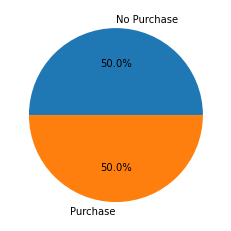

In [36]:
#check data balance
labels = 'No Purchase', 'Purchase', 
y.value_counts().plot(kind = 'pie', labels = labels, autopct='%1.1f%%')
plt.ylabel('')
plt.show()

**Part Summary**
- As the original data set is extremely imbalanced, SMOTE, an oversampling technique, is used to generate synthetic samples for the minority class. 

- After SMOTE, the modeling dataset is balanced. 

### **(3) Data Splitting using `train_test_split`**<br>

Train dataset (80%), and test dataset (20%) are chosen for modeling

In [37]:
# Data Splitting (train_test_split Cross Validation)
X_train, X_test, y_train, y_test =  train_test_split(X, 
                                                     y, 
                                                     test_size = 0.2,
                                                     random_state = 2021)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

### **(4) Modeling Performance and Selection**<br>

Logistic regression, Random Forest, Gradient Boosting and XGBoost, were chosen as the model candidates. As these are the mostly commonly used models.


Once a model is selected, its hyperparameters will be tuned. 

In [38]:
# Build the pipleines for all models
steps_lr = [('rescale', StandardScaler()),
         ('lr', LogisticRegression(n_jobs=-1))]

steps_rfc = [('rescale', StandardScaler()), 
         ('rfc', RandomForestClassifier(n_jobs=-1))]

steps_gbc = [('rescale', StandardScaler()),
             ('gbc', GradientBoostingClassifier())]

steps_xgb = [('rescale', StandardScaler()),    
         ('xgb', XGBClassifier(n_jobs=-1))]

In [39]:
#Fit data into the model
model_lr = Pipeline(steps_lr)
model_lr = model_lr.fit(X_train, y_train)

model_rfc = Pipeline(steps_rfc)
model_rfc = model_rfc.fit(X_train, y_train)

model_gbc = Pipeline(steps_gbc)
model_gbc = model_gbc.fit(X_train, y_train)

model_xgb = Pipeline(steps_xgb)
model_xgb = model_xgb.fit(X_train, y_train)

[15:36:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
#Lgistic Regression prediction
y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)

y_train_pred_proba_lr = model_lr.predict_proba(X_train)
y_test_pred_proba_lr = model_lr.predict_proba(X_test)

LogisticRegression_Loss = pd.DataFrame({'model': 'Logistic Regression',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_lr).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_lr).round(4),
#                         'train_precision':precision_score(y_train, y_train_pred_lr).round(4),
#                          'test_precision':precision_score(y_test, y_test_pred_lr).round(4),
#                          'train_recall':recall_score(y_train, y_train_pred_lr).round(4),
#                          'test_recall':recall_score(y_test, y_test_pred_lr).round(4),
                        'train_f1':f1_score(y_train, y_train_pred_lr).round(4),
                         'test_f1':f1_score(y_test, y_test_pred_lr).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_lr[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_lr[:, 1]).round(4)}, index=[0])

In [41]:
#Random Forest prediction
y_train_pred_rfc = model_rfc.predict(X_train)
y_test_pred_rfc = model_rfc.predict(X_test)

y_train_pred_proba_rfc = model_rfc.predict_proba(X_train)
y_test_pred_proba_rfc = model_rfc.predict_proba(X_test)

RandomForest_Loss = pd.DataFrame({'model': 'Random Forest',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_rfc).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_rfc).round(4),
#                         'train_precision':precision_score(y_train, y_train_pred_rfc).round(4),
#                          'test_precision':precision_score(y_test, y_test_pred_rfc).round(4),
#                          'train_recall':recall_score(y_train, y_train_pred_rfc).round(4),
#                          'test_recall':recall_score(y_test, y_test_pred_rfc).round(4),
                        'train_f1':f1_score(y_train, y_train_pred_rfc).round(4),
                         'test_f1':f1_score(y_test, y_test_pred_rfc).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_rfc[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_rfc[:, 1]).round(4)}, index=[0])

In [42]:
#Gradient Boosting prediction
y_train_pred_gbc = model_gbc.predict(X_train)
y_test_pred_gbc = model_gbc.predict(X_test)

y_train_pred_proba_gbc = model_gbc.predict_proba(X_train)
y_test_pred_proba_gbc = model_gbc.predict_proba(X_test)

GradientBoosting_Loss = pd.DataFrame({'model': 'Gradient Boosting',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_gbc).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_gbc).round(4),
#                         'train_precision':precision_score(y_train, y_train_pred_gbc).round(4),
#                          'test_precision':precision_score(y_test, y_test_pred_gbc).round(4),
#                          'train_recall':recall_score(y_train, y_train_pred_gbc).round(4),
#                          'test_recall':recall_score(y_test, y_test_pred_gbc).round(4),
                        'train_f1':f1_score(y_train, y_train_pred_gbc).round(4),
                         'test_f1':f1_score(y_test, y_test_pred_gbc).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_gbc[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_gbc[:, 1]).round(4)}, index=[0])

In [43]:
#XGBoost prediction
y_train_pred_xgb = model_xgb.predict(X_train)
y_test_pred_xgb = model_xgb.predict(X_test)

y_train_pred_proba_xgb = model_xgb.predict_proba(X_train)
y_test_pred_proba_xgb = model_xgb.predict_proba(X_test)

XGBoost_Loss = pd.DataFrame({'model': 'XGBoost',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_xgb).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_xgb).round(4),
#                         'train_precision':precision_score(y_train, y_train_pred_xgb).round(4),
#                          'test_precision':precision_score(y_test, y_test_pred_xgb).round(4),
#                          'train_recall':recall_score(y_train, y_train_pred_xgb).round(4),
#                          'test_recall':recall_score(y_test, y_test_pred_xgb).round(4),
                        'train_f1':f1_score(y_train, y_train_pred_xgb).round(4),
                         'test_f1':f1_score(y_test, y_test_pred_xgb).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_xgb[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_xgb[:, 1]).round(4)}, index=[0])

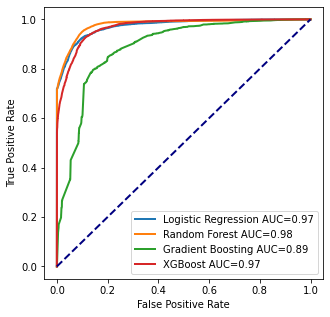

In [44]:
#define metrics
plt.figure(figsize = (5,5))
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']
y_test_pred_proba = []
y_test_pred_proba.append(y_test_pred_proba_lr[:, 1])
y_test_pred_proba.append(y_test_pred_proba_rfc[:, 1])
y_test_pred_proba.append(y_test_pred_proba_gbc[:, 1])
y_test_pred_proba.append(y_test_pred_proba_xgb[:, 1])

#create ROC curve
for n in range(len(y_test_pred_proba)):
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba[n])
    auc = roc_auc_score(y_test, y_test_pred_proba[n])
    lw = 2
    plt.plot(fpr,tpr,label=str(models[n])+" AUC="+str(auc.round(2)),lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [45]:
## Build a model_scores showing the scores of all models
model_scores = pd.concat([LogisticRegression_Loss,
                          RandomForest_Loss, 
                          GradientBoosting_Loss,
                          XGBoost_Loss],ignore_index=True)
model_scores

,model,train_accuracy,test_accuracy,train_f1,test_f1,train_auc,test_auc
0,Logistic Regression,0.9135,0.9128,0.9133,0.9126,0.9731,0.9729
1,Random Forest,0.9362,0.9234,0.9379,0.9259,0.9873,0.9788
2,Gradient Boosting,0.8179,0.8176,0.8264,0.8261,0.8881,0.8862
3,XGBoost,0.9069,0.9067,0.9083,0.9079,0.9700,0.9690


In [46]:
print(classification_report(y_test, y_test_pred_rfc))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92     23024
           1       0.90      0.96      0.93     22974

    accuracy                           0.92     45998
   macro avg       0.93      0.92      0.92     45998
weighted avg       0.93      0.92      0.92     45998



**Part Summary**
- From the score table and plot above, it is clear to see that all the models indicate almost no variance between the train and test, and the highst test_auc score (0.98), f1 score (0.93) and accuracy score (0.93) are obtained by the Random Forest. Since 0.98 is very good for classification, we thereafter use Random Forest classification model for future prediction. 

- Though we have chose Random Forest as our model, which has very small bias and variance, a rough tuning is conducted on random forest just as an example. 

## 3.2 Model hyperparameter tuning (Random Forest)

### **(1) Tuning**<br>

RandomSearchCV can be used to narrow down the range for each hyperparameter, while GridSearchCV is employed here fore hyperparameters tuning. The following hyperparameters are tuned, including `max_depth`, `min_samples_leaf`, `min_samples_split`, `max_features` and `n_estimators`. 

In [47]:
## Applying Grid Search to find the best model and the best parameters

#Define the hyperparameters to tune
grid_parameters = {'rfc__max_depth': [None, 10, 30],
              'rfc__n_estimators': [20, 50, 100],
              'rfc__class_weight': [None, 'balanced']
             }


#Define the gridsearch process
grid_search = GridSearchCV(model_rfc, 
                           grid_parameters, 
                           cv = 3, 
                           scoring = 'roc_auc', 
                           n_jobs = -1,
                           return_train_score=True)

#Applying tuning and timers
grid_search_rfc = grid_search.fit(X_train, y_train)

In [48]:
grid_search_rfc.best_params_

{'rfc__class_weight': 'balanced',
 'rfc__max_depth': None,
 'rfc__n_estimators': 100}

In [49]:
model_rfc_tune = grid_search_rfc.best_estimator_

### **(2) After Tuning**<br>

In [50]:
#Random Forest prediction
y_train_pred_rfc_tune = model_rfc_tune.predict(X_train)
y_test_pred_rfc_tune = model_rfc_tune.predict(X_test)

y_train_pred_proba_rfc_tune = model_rfc_tune.predict_proba(X_train)
y_test_pred_proba_rfc_tune = model_rfc_tune.predict_proba(X_test)

RandomForest_Loss_Tuned = pd.DataFrame({'model': 'Random Forest after Tuning',
                         'train_accuracy':accuracy_score(y_train, y_train_pred_rfc_tune).round(4),
                         'test_accuracy':accuracy_score(y_test, y_test_pred_rfc_tune).round(4),
#                           'train_precision':precision_score(y_train, y_train_pred_rfc_tune).round(4),
#                          'test_precision':precision_score(y_test, y_test_pred_rfc_tune).round(4),
#                         'train_recall':recall_score(y_train, y_train_pred_rfc_tune).round(4),
#                          'test_recall':recall_score(y_test, y_test_pred_rfc_tune).round(4),
                        'train_f1':f1_score(y_train, y_train_pred_rfc_tune).round(4),
                         'test_f1':f1_score(y_test, y_test_pred_rfc_tune).round(4),
                         'train_auc':roc_auc_score(y_train, y_train_pred_proba_rfc_tune[:, 1]).round(4),
                         'test_auc':roc_auc_score(y_test, y_test_pred_proba_rfc_tune[:, 1]).round(4)}, index=[0])

model_scores = pd.concat([model_scores,
                          RandomForest_Loss_Tuned],ignore_index=True)
model_scores

,model,train_accuracy,test_accuracy,train_f1,test_f1,train_auc,test_auc
0,Logistic Regression,0.9135,0.9128,0.9133,0.9126,0.9731,0.9729
1,Random Forest,0.9362,0.9234,0.9379,0.9259,0.9873,0.9788
2,Gradient Boosting,0.8179,0.8176,0.8264,0.8261,0.8881,0.8862
3,XGBoost,0.9069,0.9067,0.9083,0.9079,0.9700,0.9690
4,Random Forest after Tuning,0.9362,0.9234,0.9380,0.9259,0.9873,0.9786


In [51]:
#search the optimal threshold
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# keep probabilities for the positive outcome only
probs = y_test_pred_proba_rfc_tune[:,1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.3f' % (thresholds[ix], scores[ix]))

Threshold=0.518, F-Score=0.927


**Part Summary**

- As the initial model performs very well, tuning does not improve performance further.

- The optimal threshold may be 0.518 for the random forest classificer.

### **(3) Feature Importance**<br>

Though there is only two features in this data set, the feature importance is still compared to check potential hidden information. 

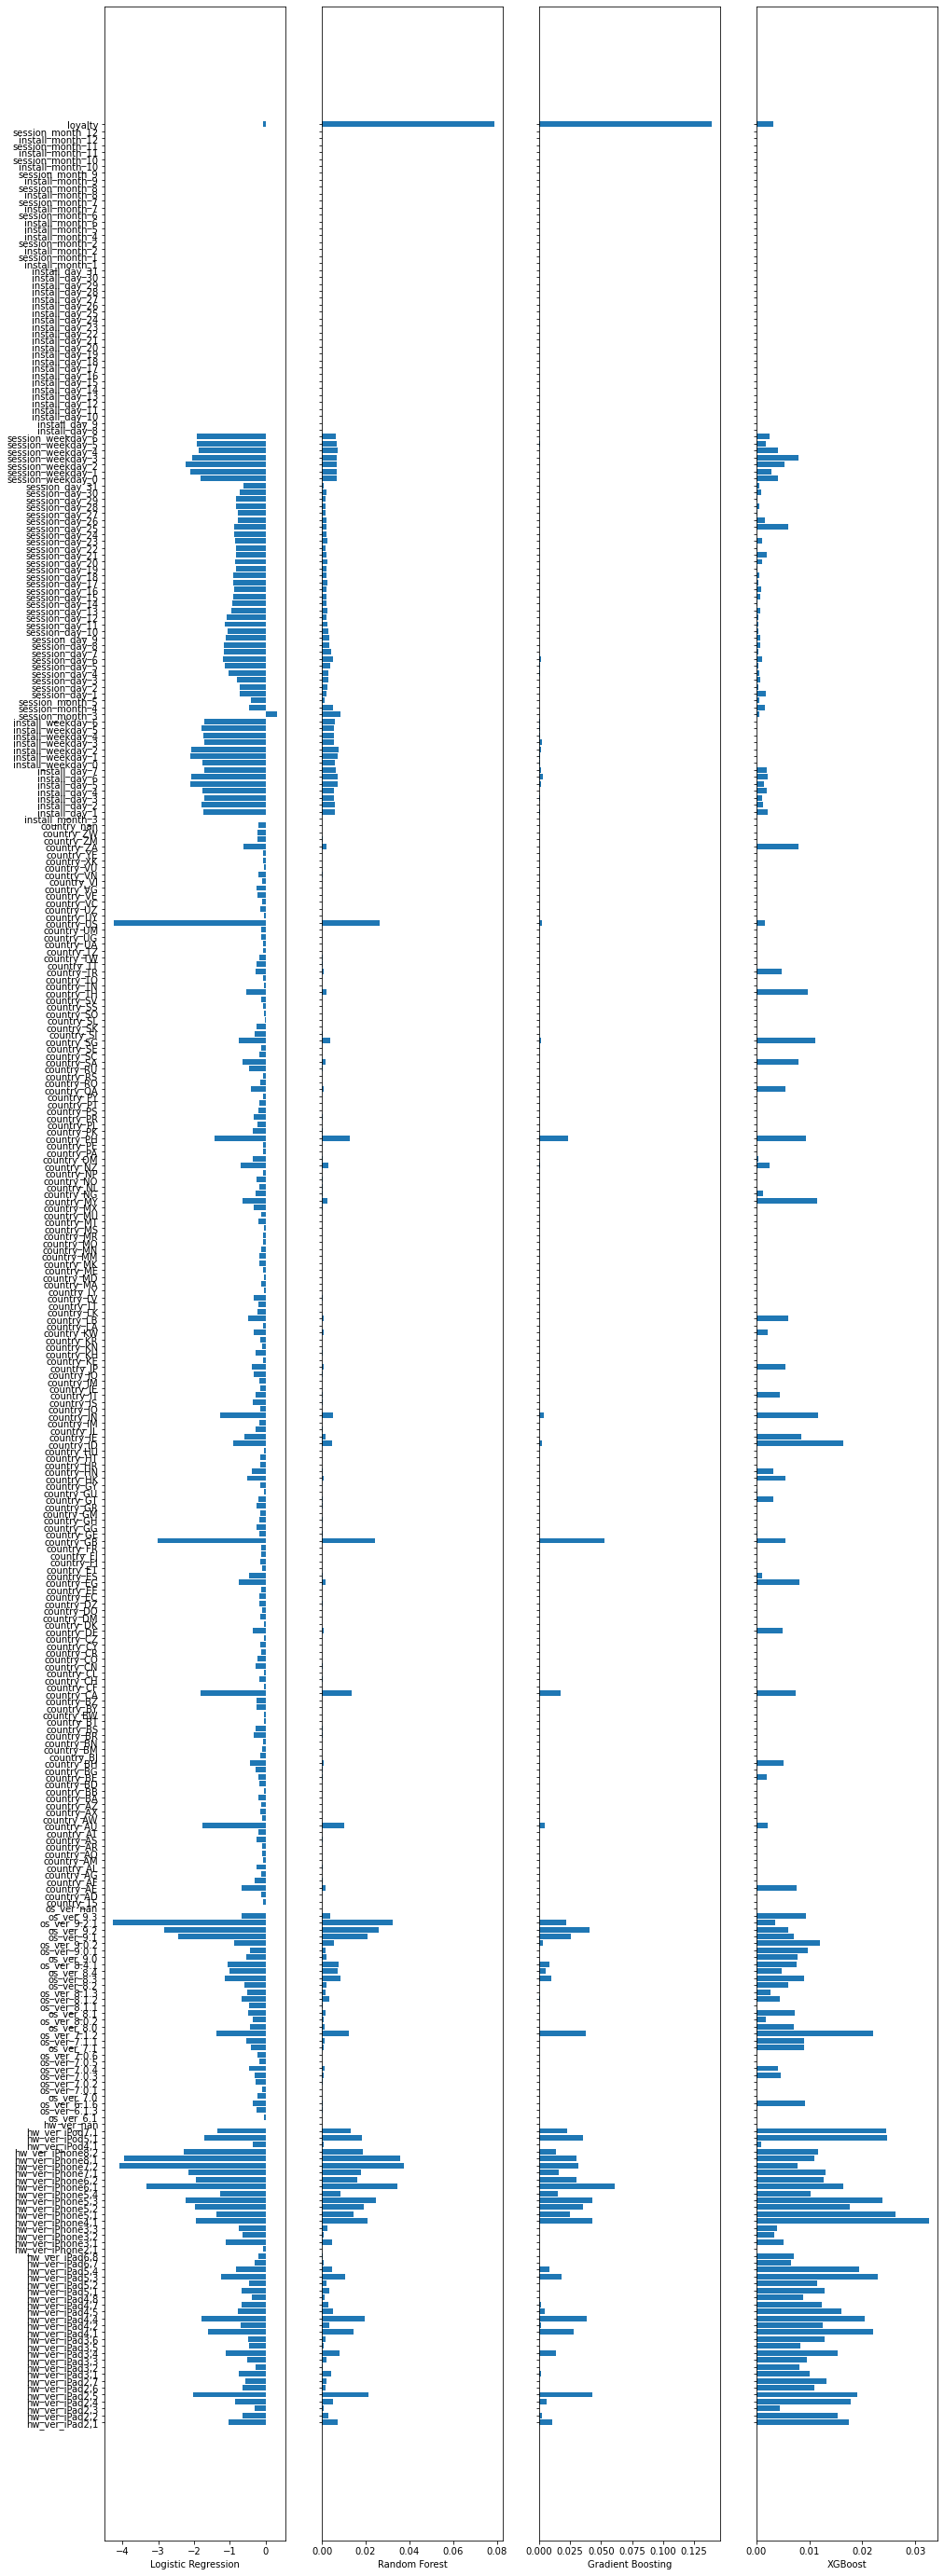

In [52]:
# Plot feature importance of all four models
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,50), sharey=True)

lr_fi = sorted([[model_lr.steps[1][1].coef_[0][n], X.columns[n]] for n in range(len(X.columns))], key=lambda x: (x[0], x[1]), reverse=True)
rfc_fi = sorted([[model_rfc.steps[1][1].feature_importances_[n], X.columns[n]] for n in range(len(X.columns))], key=lambda x: (x[0], x[1]), reverse=True)
gbc_fi = sorted([[model_gbc.steps[1][1].feature_importances_[n], X.columns[n]] for n in range(len(X.columns))], key=lambda x: (x[0], x[1]), reverse=True)
xgb_fi = sorted([[model_xgb.steps[1][1].feature_importances_[n], X.columns[n]] for n in range(len(X.columns))], key=lambda x: (x[0], x[1]), reverse=True)


ax[0].barh(X.columns, model_lr.steps[1][1].coef_[0])
ax[1].barh(X.columns, model_rfc.steps[1][1].feature_importances_)
ax[2].barh(X.columns, model_gbc.steps[1][1].feature_importances_)   
ax[3].barh(X.columns, model_xgb.steps[1][1].feature_importances_)

ax[0].set_xlabel('Logistic Regression', fontsize=10)
ax[1].set_xlabel('Random Forest', fontsize=10)
ax[2].set_xlabel('Gradient Boosting', fontsize=10)
ax[3].set_xlabel('XGBoost', fontsize=10)

plt.show()

**Part Summary**

- Different models shows different feature importance.  

- Logistic regression suggested `country_US`, `country_GB`, `os_ver_9.2.1`, `hw_ver_iPhone7.2` and `hw_ver_iPhone8.1`, `install_day` and `session_day` all contribute much in affecting the `purchase`. This corresponds to the findings in the analysis, where such groups contribute the most occurence to purchase. It is noted that logistic regression  marks `loyalty` very less important.

- This is very different from the tree based models, such as random forest and gradient boosting. These two models suggste that `loyalty` plays the most important roles in affecting the purchase decision. This makes sense to me, as it can be seen in the analysis that most of the purchases are made in the first or second day and gradually decline after that. The longer the loyalty, the less likely to make purchase, as the users may have accumulate more gems and experience and do not need to buy gems to pass. But differently, Random Forest weighs some more on the other time features, which is also reasonable, as we can see in the analysis that purchase decison varies on differet days.

- XGBoost seems to consider all the features with higher weight on iPhone and os versions, which may be due to the fact that the users with newest models or os, are more likely spend money on game purchases. This is straighforward.

- In overall, all the models look reasonable. 

# Part 4. Machine Learning Model Prediction

As future prediction is not conducted in this part, here we just save the random forest model for future use, and show a simple case of how to use this model.

### **(1) Modeling Save**<br>

In [60]:
#save the model as pickle file
import pickle

Pkl_Filename = "player_conversion_rfc.pkl"  

with open('./Prediction/'+Pkl_Filename, 'wb') as file:
    pickle.dump(model_rfc, file)

In [61]:
#check the saved pickle model
with open('./Prediction/'+Pkl_Filename, 'rb') as file:  
    player_conversion_model = pickle.load(file)

In [62]:
player_conversion_model

Pipeline(steps=[('rescale', StandardScaler()),
                ('rfc', RandomForestClassifier(n_jobs=-1))])

### **(2) Modeling Prediction**<br>

Here only random forest is used as an example, mutilple models can be run and obtain multiple results for cross validation.

In [65]:
# Build the user information
class User:
    def __init__(self, install_date, country, hw_ver, os_ver, session_date):
        self.install_date = install_date
        self.country = country
        self.hw_ver = hw_ver
        self.os_ver = os_ver
        self.session_date = session_date
    
def predict_outcome(new_user):
    # fill in the body of this function

    import pickle
    import pandas as pd
    Pkl_Filename = "player_conversion_rfc.pkl" 
    
    with open('./Prediction/'+Pkl_Filename, 'rb') as file:  
        player_conversion_model = pickle.load(file)
    
    #feature space
    df_features = pd.read_csv('./Prediction/features.csv')
    
    #temp data frame
    data = np.array([np.zeros(len(df_features.columns)).astype(int)])
    new_df = pd.DataFrame(data, columns=df_features.columns)
    
    new_df['session_month_' + str(pd.to_datetime(new_user.session_date).month)] = 1
    new_df['session_day_' + str(pd.to_datetime(new_user.session_date).day)] = 1
    new_df['session_weekday_' + str(pd.to_datetime(new_user.session_date).dayofweek)] = 1

    new_df['install_month_' + str(pd.to_datetime(new_user.install_date).month)] = 1
    new_df['install_day_' + str(pd.to_datetime(new_user.install_date).day)] = 1
    new_df['install_weekday_' + str(pd.to_datetime(new_user.install_date).dayofweek)] = 1
        
    new_df['loyalty'] = (pd.to_datetime(new_user.session_date) - pd.to_datetime(new_user.install_date)).days

    new_df['country_' + new_user.country] = 1
    new_df['hw_ver_' + new_user.hw_ver] = 1
    new_df['os_ver_' + new_user.os_ver] = 1

    return player_conversion_model.predict_proba(new_df)[0][1].round(3)

# example usage:

Dane = User('2019-3-1', 'US', 'iPhone8,1', '9.2.1', '2019-3-2')
loyalty = (pd.to_datetime(Dane.session_date) - pd.to_datetime(Dane.install_date)).days
result = predict_outcome(Dane)
print(f'The probability that Dane will purchase at Day {loyalty} is: {round(result, 3)}')

The probability that Dane will purchase at Day 1 is: 0.769


# Part 5. Project Summary

In this project, the game users' information and activities, including `users.csv`, `sessions.csv`, `spendevents.csv`, `iaps.csv`, are analyzed. It is observed that the English users, including the US, Great Britain, Canada and Austrilia, contribute the most games sessions, spendings and purchases (~85%). Therefore, this group is selected for pormotion. 

Thereafter, machine learning models are built to predict whether the English users will make purchases. If the probaility is low then promotions may be applied to them to boost purchase and revenue. 

Before modeling, the raw data as checked, merged, cleaned (dropped). For categorical features, One-Hot encoder is used for encoding. Due to the extreme imbalance of the data set, SMOTE is employed to balance the dataset via oversampling.  

As for the modeling, four most widely used models, including Logistic Regression, Random Forest, Gradient Boosting and XGBoost, were employed and compared. Their performance on the training and test sets is summerized below: 

<img src="./Graphs/AUROC.png" style="width: 400px;">
<img src="./Graphs/Model_Score.png" style="width: 800px;">

From the loss table and AUROC curves above, it is clear to see that Random Forest indicates almost no variance between the train and test and the best performance, thereby it is chosen as our model in future prediction. In addition, tuning does not improve much of model performance as the original model is already good. 